# Tarea 1 INF 395

In [ ]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 4.1 MB/s eta 0:00:00


## Integrantes:

* Nombre: Matías Francia
* Nombre: Pablo Betancourt

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

## Helper Functions

In [ ]:
def viz_imgs(imgs, labels):
    "Función para visualizar imágenes junto a sus labels"
    plt.figure(figsize=(10,10))
    random_inds = np.random.choice(imgs.shape[0],36)
    for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [ ]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Exploración de los Datos

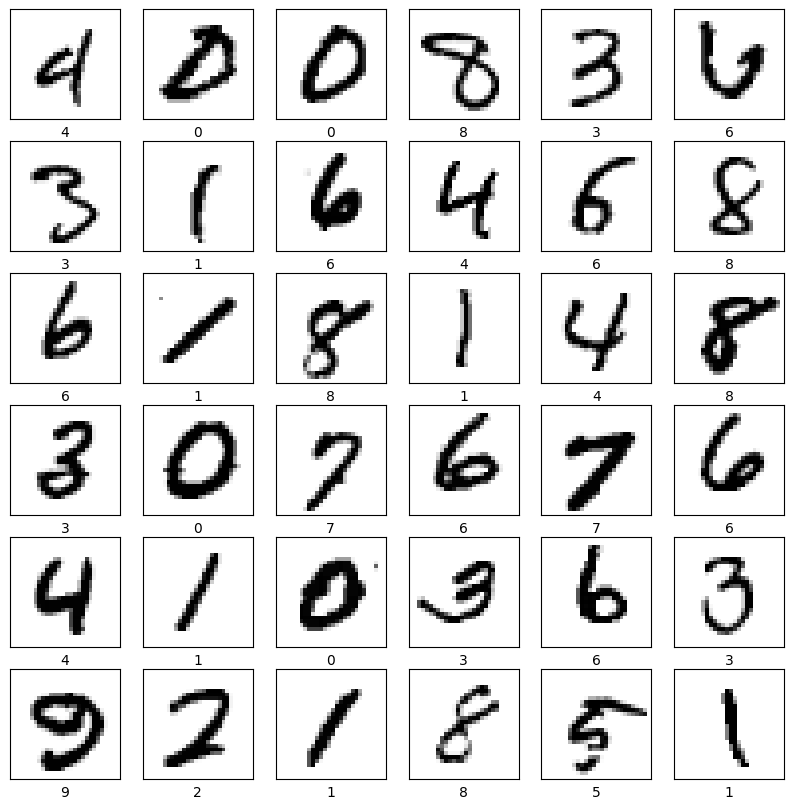

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

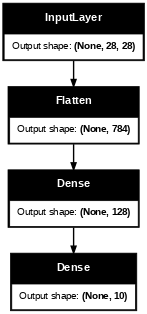

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy: 

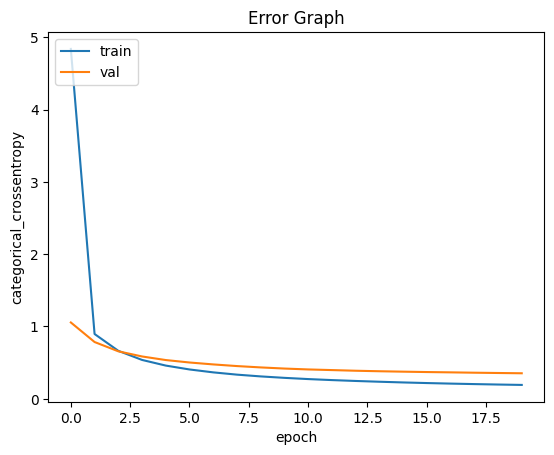

In [ ]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36804890632629395
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


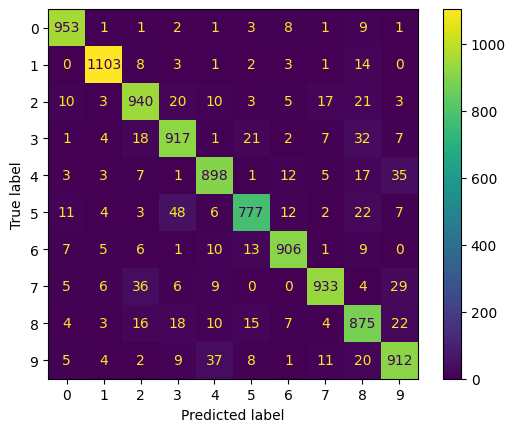

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


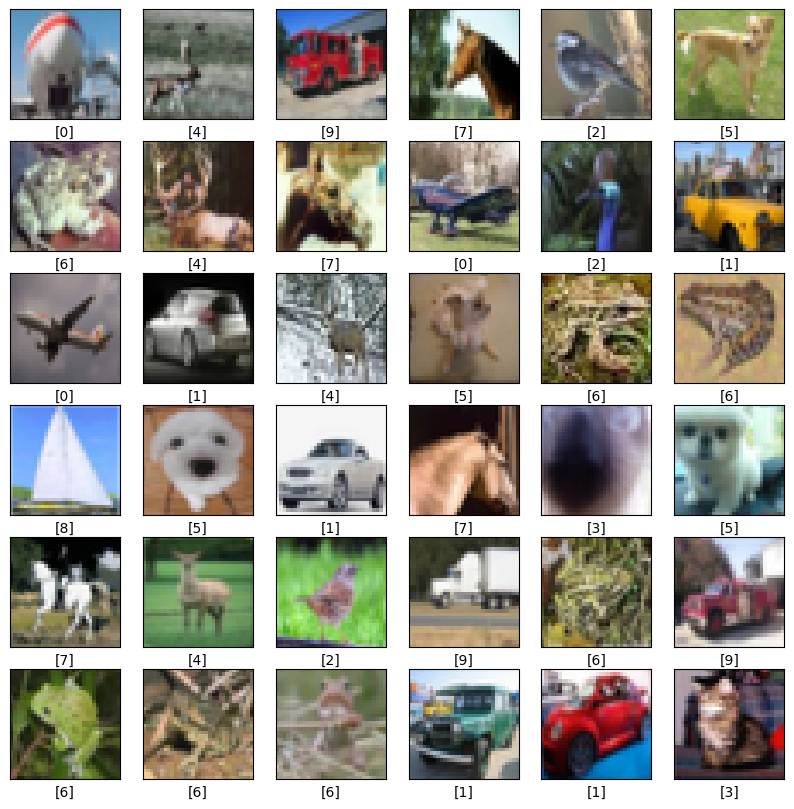

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

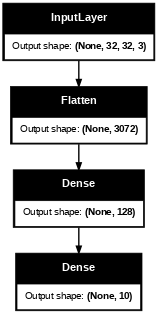

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1021 - loss: 582.5866 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1018 - loss: 2.3032 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1017 - loss: 2.3021 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1019 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy:

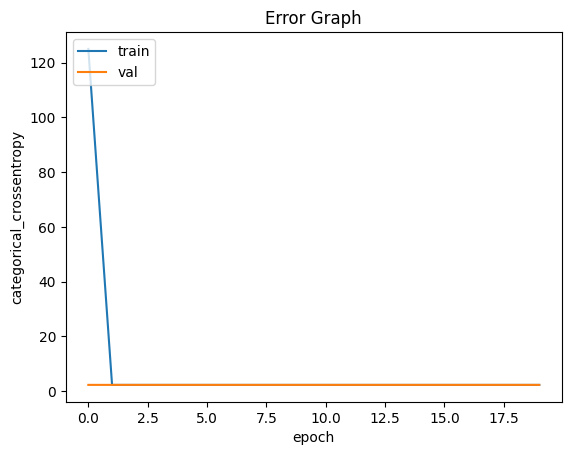

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


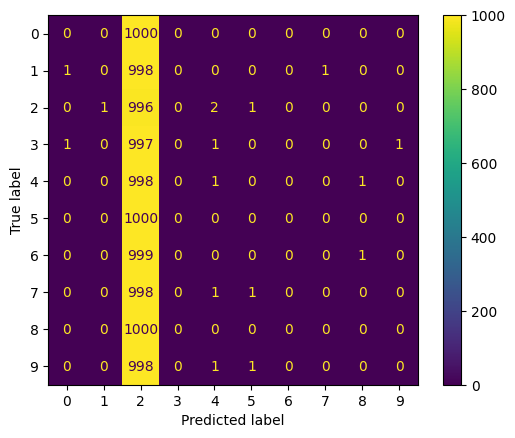

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)
plot_cm(y_pred, y_test)

In [ ]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [ ]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta: La capa de dropout funciona quitando neuronas de cada capa con una probabilidad de p (en keras, ya que en la teoría es 1-p) en una determinada iteración, generando una máscara de la red. Esto permite generalizar mejor, puesto que se favorece que cada neurona aprenda por sí misma las relaciones de los datos, sin depender de las adyacentes. Por otro lado, es importante ponderar los valores de output de cada capa en el test, puesto que se entreno, en promedio, con menos neuronas de las que se encuentran en la fase de test del modelo, por lo que si no se ajusta, la predicción tendrá un valor proporcionalmente mayor a p.`

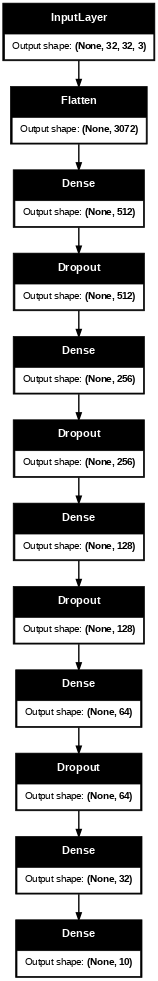

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.1602 - loss: 2.2486 - val_accuracy: 0.3037 - val_loss: 1.9452
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2929 - loss: 1.9177 - val_accuracy: 0.3428 - val_loss: 1.8358
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3307 - loss: 1.8323 - val_accuracy: 0.3656 - val_loss: 1.7692
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3526 - loss: 1.7795 - val_accuracy: 0.3796 - val_loss: 1.7245
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3698 - loss: 1.7458 - val_accuracy: 0.3927 - val_loss: 1.6873
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3852 - loss: 1.7104 - val_accuracy: 0.3914 - val_loss: 1.6985
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3944 - loss: 1.6937 - val_accuracy: 0.3941 - val_loss: 1.6893
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3962 - loss: 1.6724 - val_ac

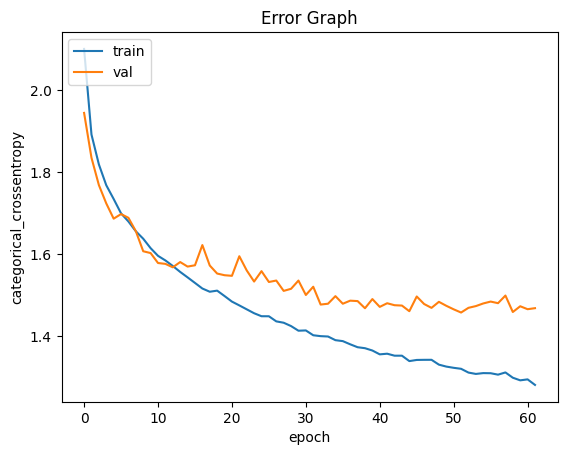

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4430652856826782
Test accuracy: 0.48829999566078186


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


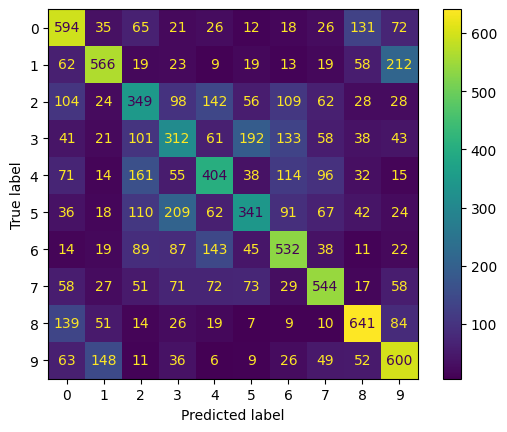

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      0.59      0.54      1000
     class 1       0.61      0.57      0.59      1000
     class 2       0.36      0.35      0.35      1000
     class 3       0.33      0.31      0.32      1000
     class 4       0.43      0.40      0.42      1000
     class 5       0.43      0.34      0.38      1000
     class 6       0.50      0.53      0.51      1000
     class 7       0.56      0.54      0.55      1000
     class 8       0.61      0.64      0.63      1000
     class 9       0.52      0.60      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta: resuelven el problema de que al comienzo del entrenamiento no se vea una gran mejoría en la precisión del modelo en redes neuronales "deep", o el problema de desvanecimiento o explosión del gradiente, esto debido a que las actualizaciones de los pesos del modelo dadas por los gradientes (mediante backpropagation) deben recorrer un camino muy largo de neuronas, provocando que en las primeras epoch del entrenamiento, la precisión del modelo se mantenga casi igual. Como solución a esto, skip connections plantea establecer conexiones entre capas de neuronas que no son adyacentes (de atrás hacia adelante) con un determinado "step", facilitando el flujo de información en el backpropagation, y permitiendo que se mejoren considerablemente algunos pesos del modelo en epochs tempranas.`

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

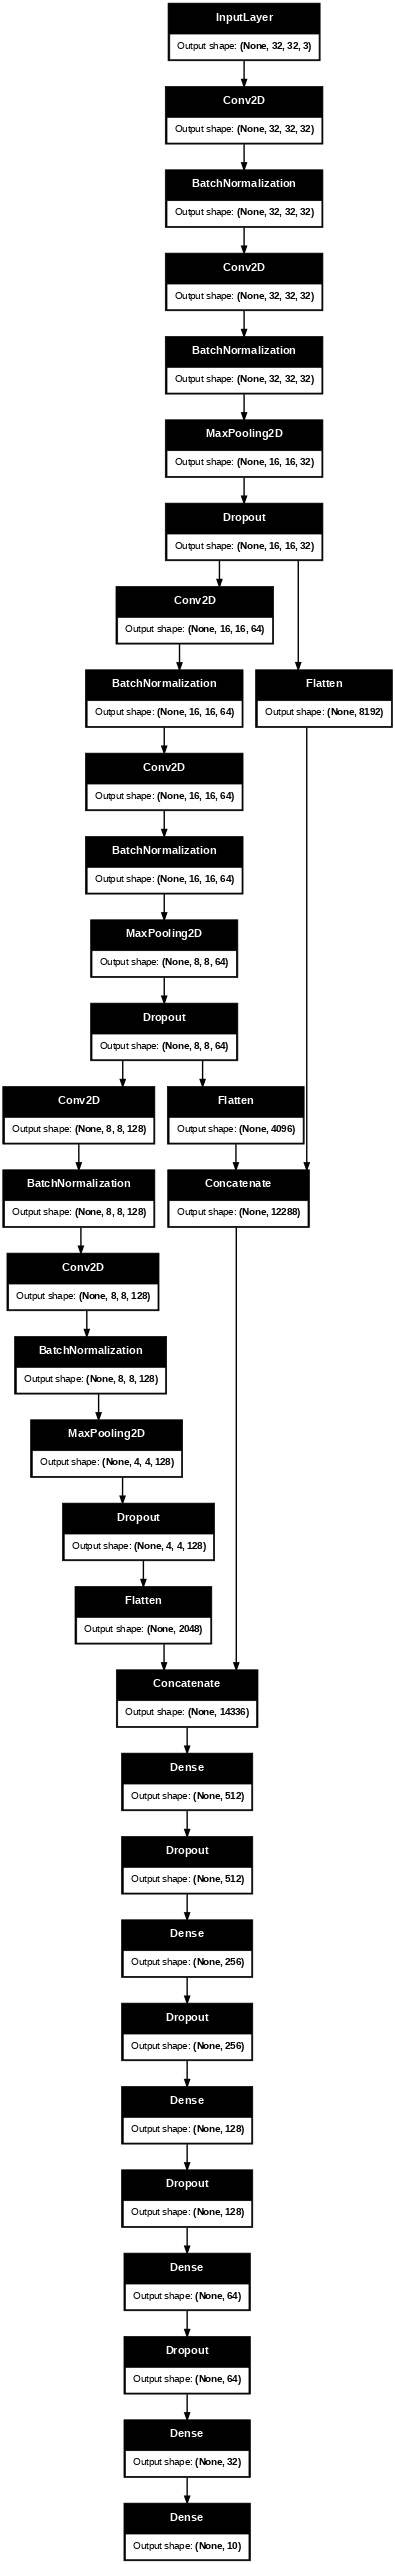

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [ ]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.2318 - loss: 2.6674 - val_accuracy: 0.3157 - val_loss: 1.7892
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4734 - loss: 1.4667 - val_accuracy: 0.5572 - val_loss: 1.2635
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5901 - loss: 1.1776 - val_accuracy: 0.6625 - val_loss: 1.0026
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6706 - loss: 0.9651 - val_accuracy: 0.7005 - val_loss: 0.8777
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7277 - loss: 0.8026 - val_accuracy: 0.7286 - val_loss: 0.8272
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7705 - loss: 0.6753 - val_accuracy: 0.7569 - val_loss: 0.7746
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8083 - loss: 0.5741 - val_accuracy: 0.7600 - val_loss: 0.7726
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8397 - loss: 0.480

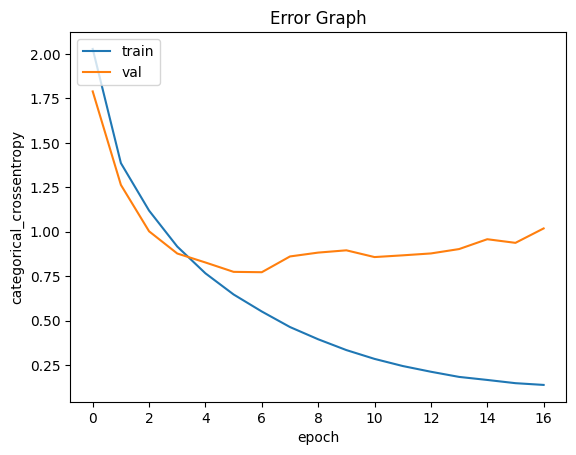

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7994195818901062
Test accuracy: 0.7505999803543091


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


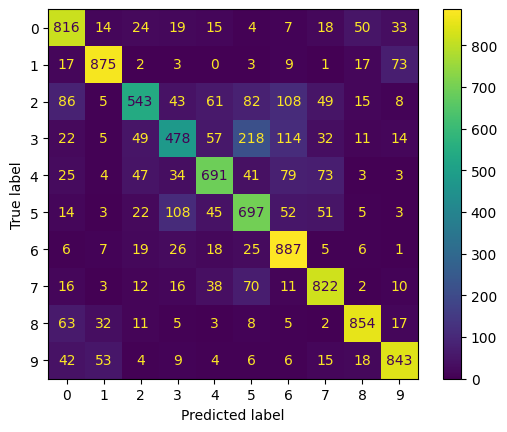

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.74      0.82      0.77      1000
     class 1       0.87      0.88      0.87      1000
     class 2       0.74      0.54      0.63      1000
     class 3       0.65      0.48      0.55      1000
     class 4       0.74      0.69      0.72      1000
     class 5       0.60      0.70      0.65      1000
     class 6       0.69      0.89      0.78      1000
     class 7       0.77      0.82      0.79      1000
     class 8       0.87      0.85      0.86      1000
     class 9       0.84      0.84      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [ ]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

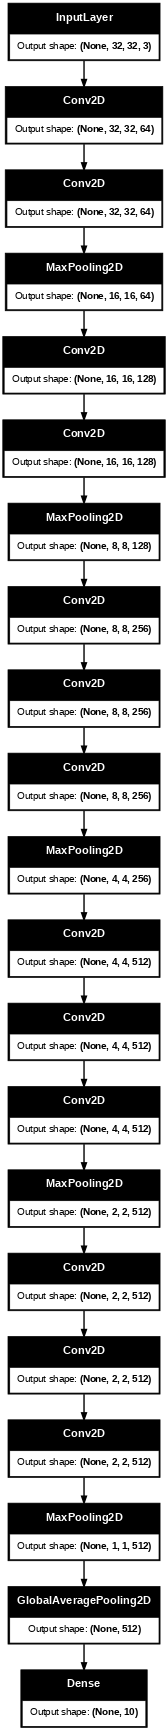

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.2907 - loss: 2.0249 - val_accuracy: 0.4853 - val_loss: 1.5376
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5002 - loss: 1.4875 - val_accuracy: 0.5189 - val_loss: 1.4136
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5312 - loss: 1.3800 - val_accuracy: 0.5375 - val_loss: 1.3556
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5509 - loss: 1.3241 - val_accuracy: 0.5481 - val_loss: 1.3198
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5632 - loss: 1.2874 - val_accuracy: 0.5561 - val_loss: 1.2950
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5717 - loss: 1.2607 - val_accuracy: 0.5617 - val_loss: 1.2768
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5779 - loss: 1.2400 - val_accuracy: 0.5663 - val_loss: 1.2627
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5832 - loss: 1.

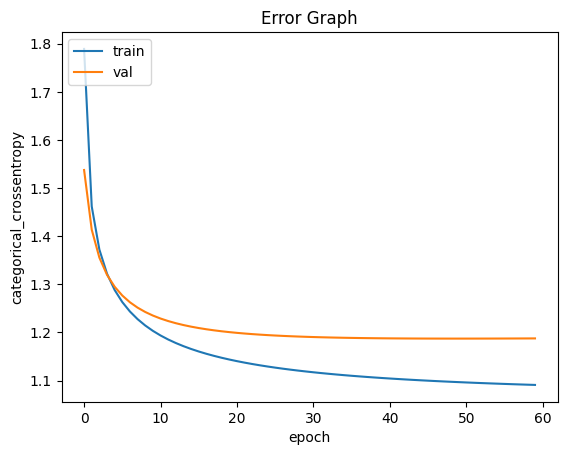

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1918492317199707
Test accuracy: 0.5856999754905701


In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.66      0.64      1000
     class 1       0.62      0.68      0.65      1000
     class 2       0.51      0.47      0.49      1000
     class 3       0.44      0.39      0.41      1000
     class 4       0.54      0.54      0.54      1000
     class 5       0.57      0.47      0.51      1000
     class 6       0.58      0.72      0.64      1000
     class 7       0.64      0.65      0.64      1000
     class 8       0.69      0.71      0.70      1000
     class 9       0.61      0.58      0.60      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Steel_industry_data.csv to Steel_industry_data.csv


In [ ]:
df = pd.read_csv('Steel_industry_data.csv')

In [ ]:
df.head()

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4                         64.72                         100.0  4500   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load  
4    Weekday      Monday  Light_Load

Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

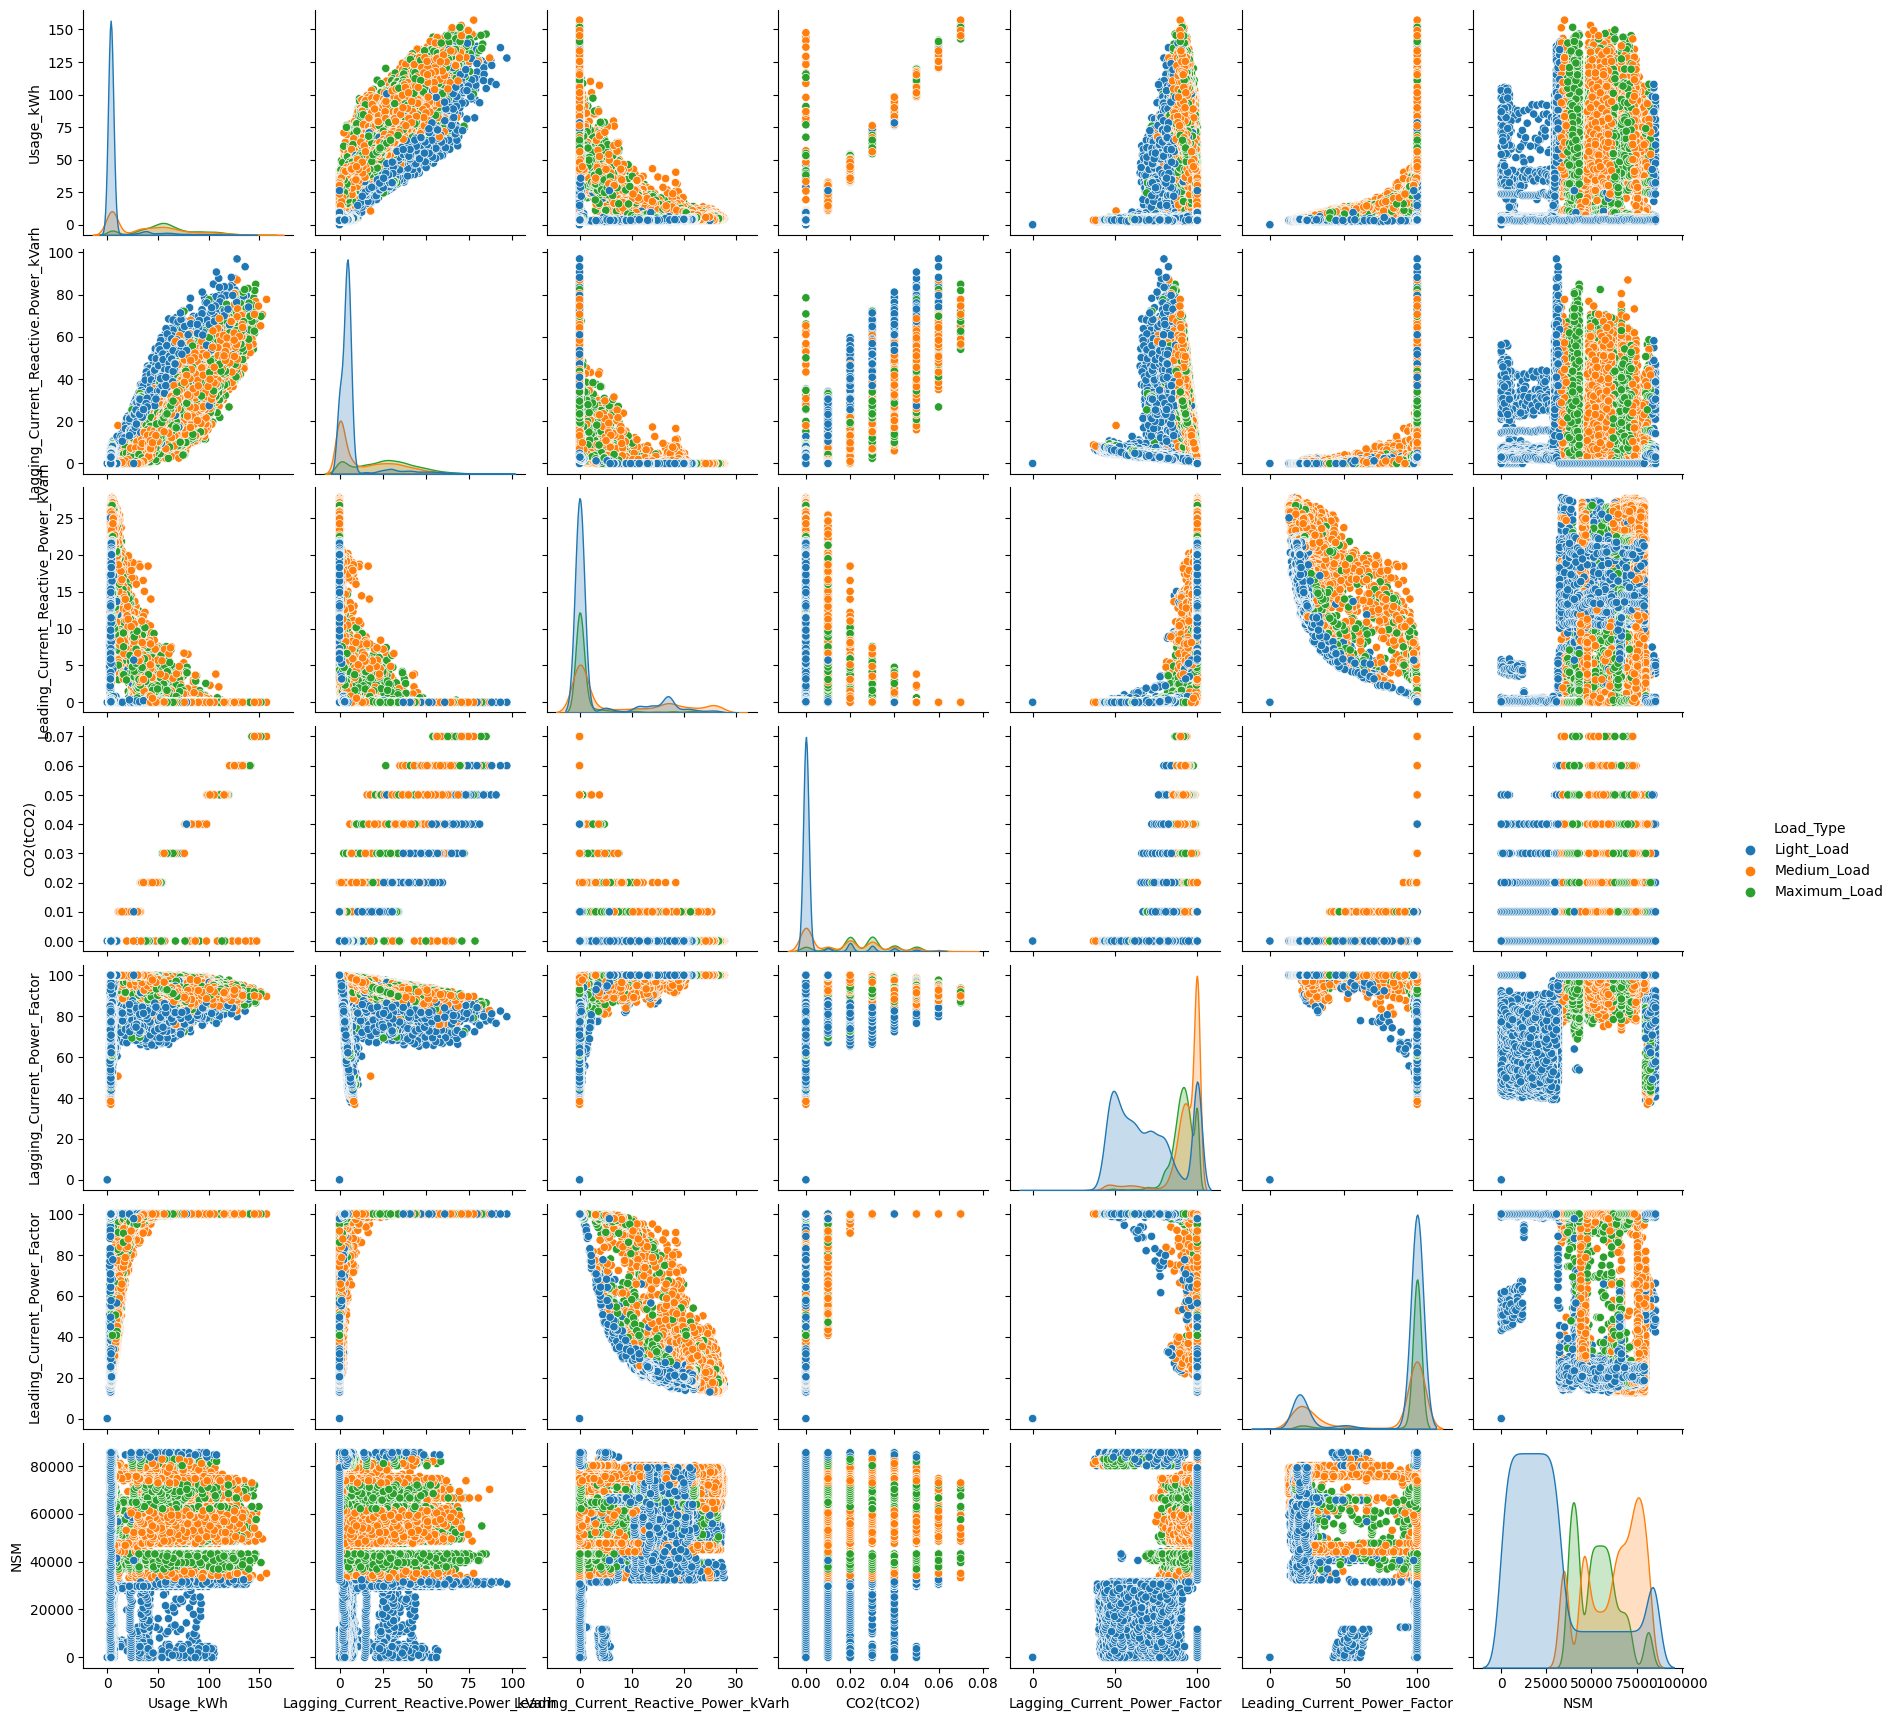

In [ ]:
sns.pairplot(df, hue='Load_Type')

<Axes: xlabel='Load_Type', ylabel='Count'>

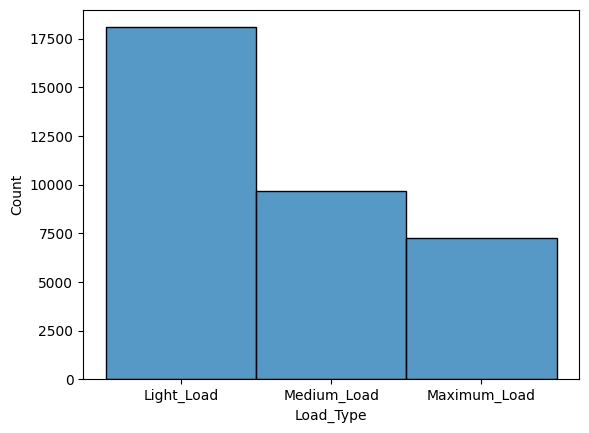

In [ ]:
#Gráficos del EDA
### START CODE HERE ###
sns.histplot(data=df, x="Load_Type")

<ipython-input-94-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

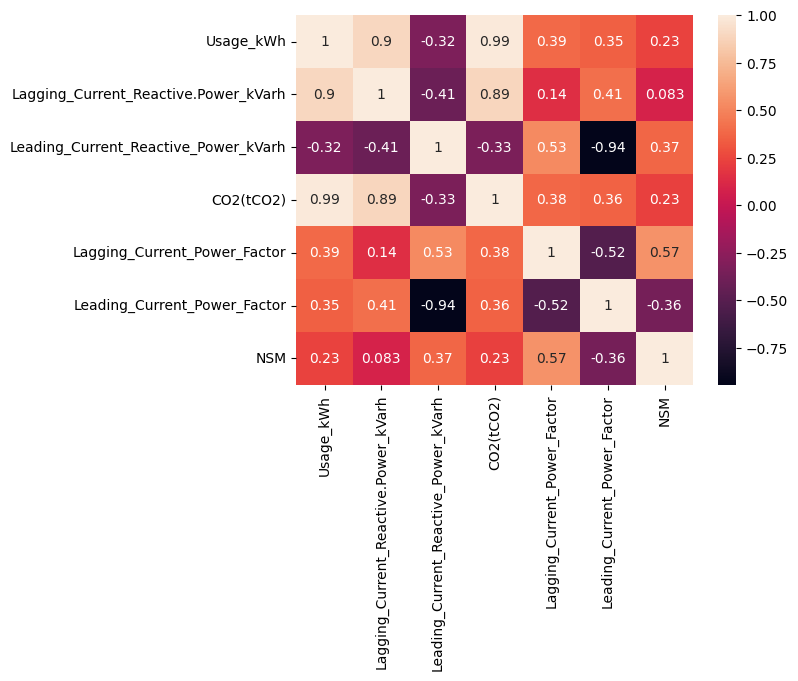

In [ ]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='Load_Type', ylabel='Usage_kWh'>

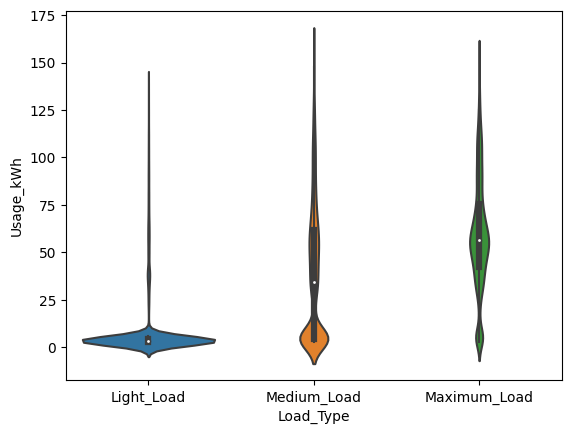

In [ ]:
sns.violinplot(y = "Usage_kWh",
            x = "Load_Type",
            data = df)

`Respuesta`: `En el histograma podemos notar que la mayor cantidad de datos son de la clase target Light Load (alrededor de 17.500 datos), y que la que tiene menos datos es Maximum Load (teniendo alrededor de 7.500). En el mapa de calor, podemos notar que Leading_Current_Power_Factor está estrechamente relacionado con Leading_Current_Reactive_Power_kVarh y Usage_kWh, al igual que Usage_kWh y CO2(tCO2). Por último, en el "gráfico de violín" podemos notar que los datos de la categoría Light_Load (en Load_Type) tienen una concentración de Usage_kWh en el rango 0-10, y se encuentran bastante concentrados. Los de la categoría Medium_Load se concentran más uniformemente en el rango 0-75 y los Maximum_Load se concentran principalmente en el rango 25-75, dándonos cuenta de que si bien el Feature Load_Type es categórico y el target es numérico, ambos están bastante relacionados`.

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [ ]:
# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
# X = df.drop(columns = ["Usage_kWh"])
# y = df["Usage_kWh"]
df_train, df_test = train_test_split(df, test_size=0.1, random_state=SEED)


*   `Training`: `permitir que el modelo aprenda de los datos, es decir, que descubra patrones y relaciones entre ellos`.
*   `Validation`: `encontrar buenos hiperparámetros para el modelo, a través de técnicas como cross-validation o similares`.
*   `Testing`: `validar si el modelo es capaz de predecir correctamente para datos que no se utilizaron en el entrenamiento, es decir, que no el modelo aún no conoce`.



### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

In [ ]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [ ]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

sin_day   cos_day
0  0.017213  0.999852
1  0.034422  0.999407
2  0.051620  0.998667
3  0.068802  0.997630
4  0.085965  0.996298

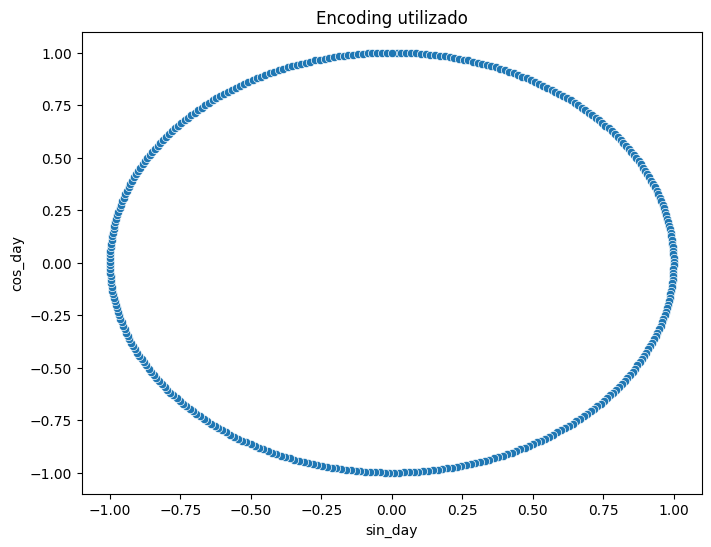

In [ ]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`: `La utilidad de ese preprocesamiento de datos es la de poder representar fechas o variables cíclicas, sin tener que usar one-hot encoding, y permitiendo representar la distancia real entre los datos (como que el domingo está un día después que el lunes, o que el Miércoles está equidistante entre el Lunes y el Viernes, pero no así entre el Martes y el Domingo)`.

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: `One-Hot Encoding transforma un vector de clases en una matriz de tantas filas como elementos del vector, y de tantas columnas como clases existan en él. Además, en cada vector fila queda un 1 en la columna asociada a la clase a la que pertenece ese valor, y un 0 en todas las otras`.
*   `Ordinal Encoding`: `Ordinal Encoding transforma un vector de clases en un vector de enteros con valores entre 0 y la cantidad de clases - 1, con cada clase asociada a un entero, los cuales no se repiten a menos que haya más de un elemento de esa clase dentro del arreglo original. Se utiliza en arreglos de features (2D)`.
*   `Label Encoding`: `Label Encoding se utiliza para codificar las etiquetas del target con valores entre 0 y n_clases - 1, de manera similar Ordinal Encoding, a pesar de que este tipo de encoding no se utiliza en el conjunto de features. Se utiliza en arreglos de target (1D)`.

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [ ]:
# preprocesamiendo indicado
### START CODE HERE ###

# MinMax Scaler
minMaxScaler = MinMaxScaler()

df_train[["CO2(tCO2)", "NSM"]] = minMaxScaler.fit_transform(df_train[["CO2(tCO2)", "NSM"]])
df_test[["CO2(tCO2)", "NSM"]] = minMaxScaler.transform(df_test[["CO2(tCO2)", "NSM"]])

# df_train[["CO2(tCO2)", "NSM", "Usage_kWh"]] = minMaxScaler.fit_transform(df_train[["CO2(tCO2)", "NSM", "Usage_kWh"]])
# df_test[["CO2(tCO2)", "NSM", "Usage_kWh"]] = minMaxScaler.transform(df_test[["CO2(tCO2)", "NSM", "Usage_kWh"]])

In [ ]:
# Standard Scaler

standardScaler = StandardScaler()

df_train[["Lagging_Current_Reactive.Power_kVarh",
         "Leading_Current_Reactive_Power_kVarh",
         "Lagging_Current_Power_Factor",
         "Leading_Current_Power_Factor"]] = standardScaler.fit_transform(df_train[["Lagging_Current_Reactive.Power_kVarh",
         "Leading_Current_Reactive_Power_kVarh",
         "Lagging_Current_Power_Factor",
         "Leading_Current_Power_Factor"]])

df_test[["Lagging_Current_Reactive.Power_kVarh",
         "Leading_Current_Reactive_Power_kVarh",
         "Lagging_Current_Power_Factor",
         "Leading_Current_Power_Factor"]] = standardScaler.transform(df_test[["Lagging_Current_Reactive.Power_kVarh",
         "Leading_Current_Reactive_Power_kVarh",
         "Lagging_Current_Power_Factor",
         "Leading_Current_Power_Factor"]])

In [ ]:
# Ordinal Encoder

ordinalEncoder = OrdinalEncoder()

df_train[["Load_Type"]] = ordinalEncoder.fit_transform(df_train[["Load_Type"]])
df_test[["Load_Type"]] = ordinalEncoder.transform(df_test[["Load_Type"]])

In [ ]:
# One-Hot Encoder

a = pd.get_dummies(df_train['WeekStatus'],prefix='WeekStatus')
b = pd.get_dummies(df_test['WeekStatus'],prefix='WeekStatus')

df_train = pd.concat([df_train,a],axis=1)
df_test = pd.concat([df_test,b],axis=1)

df_train.drop(['WeekStatus'], axis=1, inplace=True)
df_test.drop(['WeekStatus'], axis=1, inplace=True)

In [ ]:
date_train = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_train['month'] = date_train.dt.month
df_train['year'] = date_train.dt.year
df_train['hour'] = date_train.dt.hour
df_train['day'] = date_train.dt.day

date_test = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')
df_test['month'] = date_test.dt.month
df_test['year'] = date_test.dt.year
df_test['hour'] = date_test.dt.hour
df_test['day'] = date_test.dt.day

df_train = df_train.drop(columns = ["date"])
df_test = df_test.drop(columns = ["date"])

In [ ]:
df_train = preprocess_time(df_train, "month", 12)
df_train = preprocess_time(df_train, "hour", 24)
df_train = preprocess_time(df_train, "day", 30)

df_test = preprocess_time(df_test, "month", 12)
df_test = preprocess_time(df_test, "hour", 24)
df_test = preprocess_time(df_test, "day", 30)

In [ ]:
labelEncoder = LabelEncoder()

df_train["Day_of_week"] = labelEncoder.fit_transform(df_train["Day_of_week"])
df_test["Day_of_week"] = labelEncoder.transform(df_test["Day_of_week"])

In [ ]:
df_test.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
11356       2.88                             -0.565158   
26543      60.77                              2.147229   
2445      120.42                              2.860918   
14649       3.13                             -0.799577   
32699      58.86                              0.488500   

       Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
11356                             -0.522085   0.000000   
26543                             -0.522085   0.428571   
2445                              -0.522085   0.857143   
14649                              1.712400   0.000000   
32699                             -0.522085   0.428571   

       Lagging_Current_Power_Factor  Leading_Current_Power_Factor       NSM  \
11356                     -1.079947                      0.513479  0.305263   
26543                     -0.113953                      0.513479  0.505263   
2445                       0.475906                      0.513479  0.484211   
14649                      1.025560                     -2.160810  0.610526   
32699                      0.718198                      0.513479  0.631579   

       Day_of_week  Load_Type  WeekStatus_Weekday  WeekStatus_Weekend  year  \
11356            3        0.0                   0                   1  2018   
26543            4        1.0                   1                   0  2018   
2445             0        1.0                   1                   0  2018   
14649            2        0.0                   0                   1  2018   
32699            0        2.0                   1                   0  2018   

          sin_month  cos_month      sin_hour  cos_hour   sin_day   cos_day  
11356  8.660254e-01  -0.500000  9.659258e-01 -0.258819 -0.207912  0.978148  
26543 -8.660254e-01   0.500000  1.224647e-16 -1.000000  0.743145  0.669131  
2445   5.000000e-01   0.866025  2.588190e-01 -0.965926 -0.743145  0.669131  
14649  1.224647e-16  -1.000000 -5.000000e-01 -0.866025  0.406737  0.913545  
32699 -2.449294e-16   1.000000 -7.071068e-01 -0.707107  0.994522  0.104528

### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [ ]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
y_train = df_train["Usage_kWh"]
X_train = df_train.drop(columns=["Usage_kWh"])

y_test = df_test["Usage_kWh"]
X_test = df_test.drop(columns=["Usage_kWh"])

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [ ]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(500, activation='relu')(inputs)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(150, activation='relu')(x)
x = keras.layers.Dense(60, activation='relu')(x)

output = keras.layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 17)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 500)               │      9,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 500)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 150)               │     75,150 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 60)                │      9,060 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 1)                 │         61 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 93,271 (364.34 KB)

 Trainable params: 93,271 (364.34 KB)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: `Una neurona, y con una función de activación "linear", dado que necesitamos que prediga un valor numérico continuo`.

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [ ]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)

model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [ ]:
X_train.shape, X_test.shape

((31536, 17), (3504, 17))

In [ ]:
### START CODE HERE ###
epochs = 200
batch_size = 100
val_split = 0.1111
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

### 2.6 Entrenando el Modelo

In [ ]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3087.2187 - mean_absolute_error: 39.0531 - mean_squared_error: 3087.2319 - root_mean_squared_error: 51.8083 - val_loss: 1142.6183 - val_mean_absolute_error: 26.2838 - val_mean_squared_error: 1169.9092 - val_root_mean_squared_error: 34.2039
Epoch 2/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1150.9126 - mean_absolute_error: 28.1612 - mean_squared_error: 1150.9218 - root_mean_squared_error: 33.9136 - val_loss: 1028.3381 - val_mean_absolute_error: 23.6054 - val_mean_squared_error: 1053.9468 - val_root_mean_squared_error: 32.4645
Epoch 3/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 884.8614 - mean_absolute_error: 23.6194 - mean_squared_error: 884.8697 - root_mean_squared_error: 29.6642 - val_loss: 186.5206 - val_mean_absolute_error: 8.9754 - val_mean_squared_error: 190.0232 - val_root_mean_squared_error: 13.7849
Epoch 4/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 222.9107 - mean_absolute_error: 11.1789 

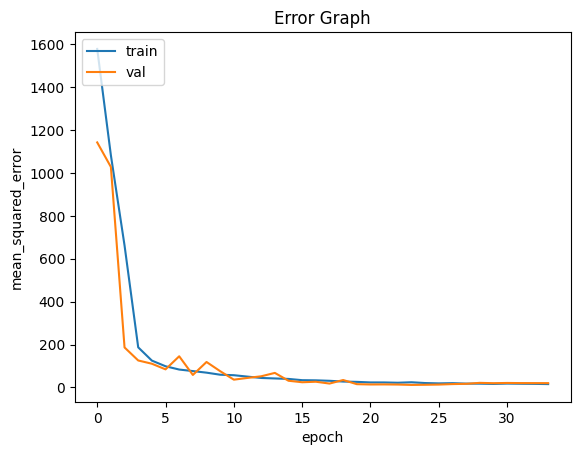

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])

Test loss: 10.346677780151367


In [ ]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.9906615406068022


### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [ ]:
model.save('steel_ind_regressionMSE10.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.